In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
import ast
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
conversations = pd.read_csv(
    "/Users/nishithranjanbiswas/Desktop/NLP/Cornell-Movie-Dialog-Analysis-NLP-Course-Project-/data/movie_conversations.tsv", 
    sep='\t', 
    encoding='ISO-8859-2',
    names = ['charID_1', 'charID_2', 'movieID', 'conversation']
)

In [3]:
lines = pd.read_csv(
    "/Users/nishithranjanbiswas/Desktop/NLP/Cornell-Movie-Dialog-Analysis-NLP-Course-Project-/data/movie_lines.tsv", 
    encoding='utf-8-sig', 
    sep='\t', 
    on_bad_lines="skip", 
    header = None,
    names = ['lineID', 'charID', 'movieID', 'charName', 'text'],
    index_col=['lineID']
)

In [4]:
characters = pd.read_csv(
    "/Users/nishithranjanbiswas/Desktop/NLP/Cornell-Movie-Dialog-Analysis-NLP-Course-Project-/data/movie_characters_metadata.tsv", 
    sep='\t', 
    header = None,
    on_bad_lines= "skip",
    names = ['charID','charName','movieID','movieName','gender','score'],
    index_col=['charID']
)

In [5]:
titles = pd.read_csv(
    "/Users/nishithranjanbiswas/Desktop/NLP/Cornell-Movie-Dialog-Analysis-NLP-Course-Project-/data/movie_titles_metadata.tsv",
    sep='\t',
    header=None,
    on_bad_lines="skip",
    names=['movieID', 'title', 'year', 'ratingIMDB', 'votes', 'genresIMDB'],
    index_col=['movieID']
)

In [6]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nishithranjanbiswas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nishithranjanbiswas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
def check_columns_existence(df, columns):
    for col in columns:
        if col not in df.columns:
            print(f"The column '{col}' does not exist in DataFrame")
        else:
            print(f"The column '{col}' exists in DataFrame")

# Check if columns exist in each DataFrame
check_columns_existence(characters, ['charName'])
check_columns_existence(titles, ['title'])
check_columns_existence(lines, ['charName', 'text'])
check_columns_existence(conversations, ['charID_1', 'charID_2', 'movieID', 'conversation'])

The column 'charName' exists in DataFrame
The column 'title' exists in DataFrame
The column 'charName' exists in DataFrame
The column 'text' exists in DataFrame
The column 'charID_1' exists in DataFrame
The column 'charID_2' exists in DataFrame
The column 'movieID' exists in DataFrame
The column 'conversation' exists in DataFrame


In [8]:
def get_movie_list(movies):
    movie_list = movies['title'].tolist()
    return movie_list

In [9]:
movie_list = get_movie_list(titles)
print(movie_list[:10])

['10 things i hate about you', '1492: conquest of paradise', '15 minutes', '2001: a space odyssey', '48 hrs.', 'the fifth element', '8mm', 'a nightmare on elm street 4: the dream master', 'a nightmare on elm street: the dream child', 'the atomic submarine']


In [10]:
len(movie_list)

617

In [11]:
def get_chracter_list(character):
    character_list = character['charName'].tolist()
    return character_list

In [12]:
character_list = get_chracter_list(characters)
print(character_list[:10])

['BIANCA', 'BRUCE', 'CAMERON', 'CHASTITY', 'JOEY', 'KAT', 'MANDELLA', 'MICHAEL', 'MISS PERKY', 'PATRICK']


In [13]:
len(character_list)

9034

In [14]:
def get_genre_list(genres):
    genre_list = genres['genresIMDB'].tolist()
    return genre_list

In [15]:
genre_list = get_genre_list(titles)
print(genre_list[:10])

["['comedy' 'romance']", "['adventure' 'biography' 'drama' 'history']", "['action' 'crime' 'drama' 'thriller']", "['adventure' 'mystery' 'sci-fi']", "['action' 'comedy' 'crime' 'drama' 'thriller']", "['action' 'adventure' 'romance' 'sci-fi' 'thriller']", "['crime' 'mystery' 'thriller']", "['fantasy' 'horror' 'thriller']", "['fantasy' 'horror' 'thriller']", "['sci-fi' 'thriller']"]


In [16]:
type(genre_list)

list

In [17]:
# Initialize an empty list to store all genres
all_genres = []

# Loop through each nested list and extract genres
for genres in genre_list:
    if isinstance(genres, str):
        # Remove the brackets and split the string into individual genres
        cleaned_genres = genres.strip("[]").replace("'", "").split()
        # Extend the all_genres list with the cleaned genres
        all_genres.extend(cleaned_genres)

# Convert the list to a set to remove duplicates and then back to a sorted list
unique_genres_list = sorted(set(all_genres))

# Display the unique genres
print(unique_genres_list)

['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sci-fi', 'short', 'sport', 'thriller', 'war', 'western']


In [18]:
len(unique_genres_list)

24

In [19]:
index_labels = titles.index
print(index_labels)

Index(['m0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9',
       ...
       'm607', 'm608', 'm609', 'm610', 'm611', 'm612', 'm613', 'm614', 'm615',
       'm616'],
      dtype='object', name='movieID', length=617)


In [20]:
titles.head()

,title,year,ratingIMDB,votes,genresIMDB
movieID,,,,,
m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


In [21]:
print(all_genres)

['comedy', 'romance', 'adventure', 'biography', 'drama', 'history', 'action', 'crime', 'drama', 'thriller', 'adventure', 'mystery', 'sci-fi', 'action', 'comedy', 'crime', 'drama', 'thriller', 'action', 'adventure', 'romance', 'sci-fi', 'thriller', 'crime', 'mystery', 'thriller', 'fantasy', 'horror', 'thriller', 'fantasy', 'horror', 'thriller', 'sci-fi', 'thriller', 'drama', 'mystery', 'thriller', 'action', 'drama', 'thriller', 'comedy', 'romance', 'sci-fi', 'comedy', 'romance', 'crime', 'drama', 'sci-fi', 'thriller', 'action', 'sci-fi', 'thriller', 'biography', 'drama', 'music', 'horror', 'romance', 'drama', 'action', 'western', 'drama', 'thriller', 'drama', 'thriller', 'action', 'adventure', 'comedy', 'crime', 'action', 'adventure', 'thriller', 'comedy', 'romance', 'action', 'crime', 'drama', 'mystery', 'thriller', 'crime', 'drama', 'comedy', 'drama', 'music', 'drama', 'romance', 'war', 'crime', 'drama', 'mystery', 'thriller', 'adventure', 'drama', 'fantasy', 'comedy', 'crime', 'roman

In [22]:
len(all_genres)


1868

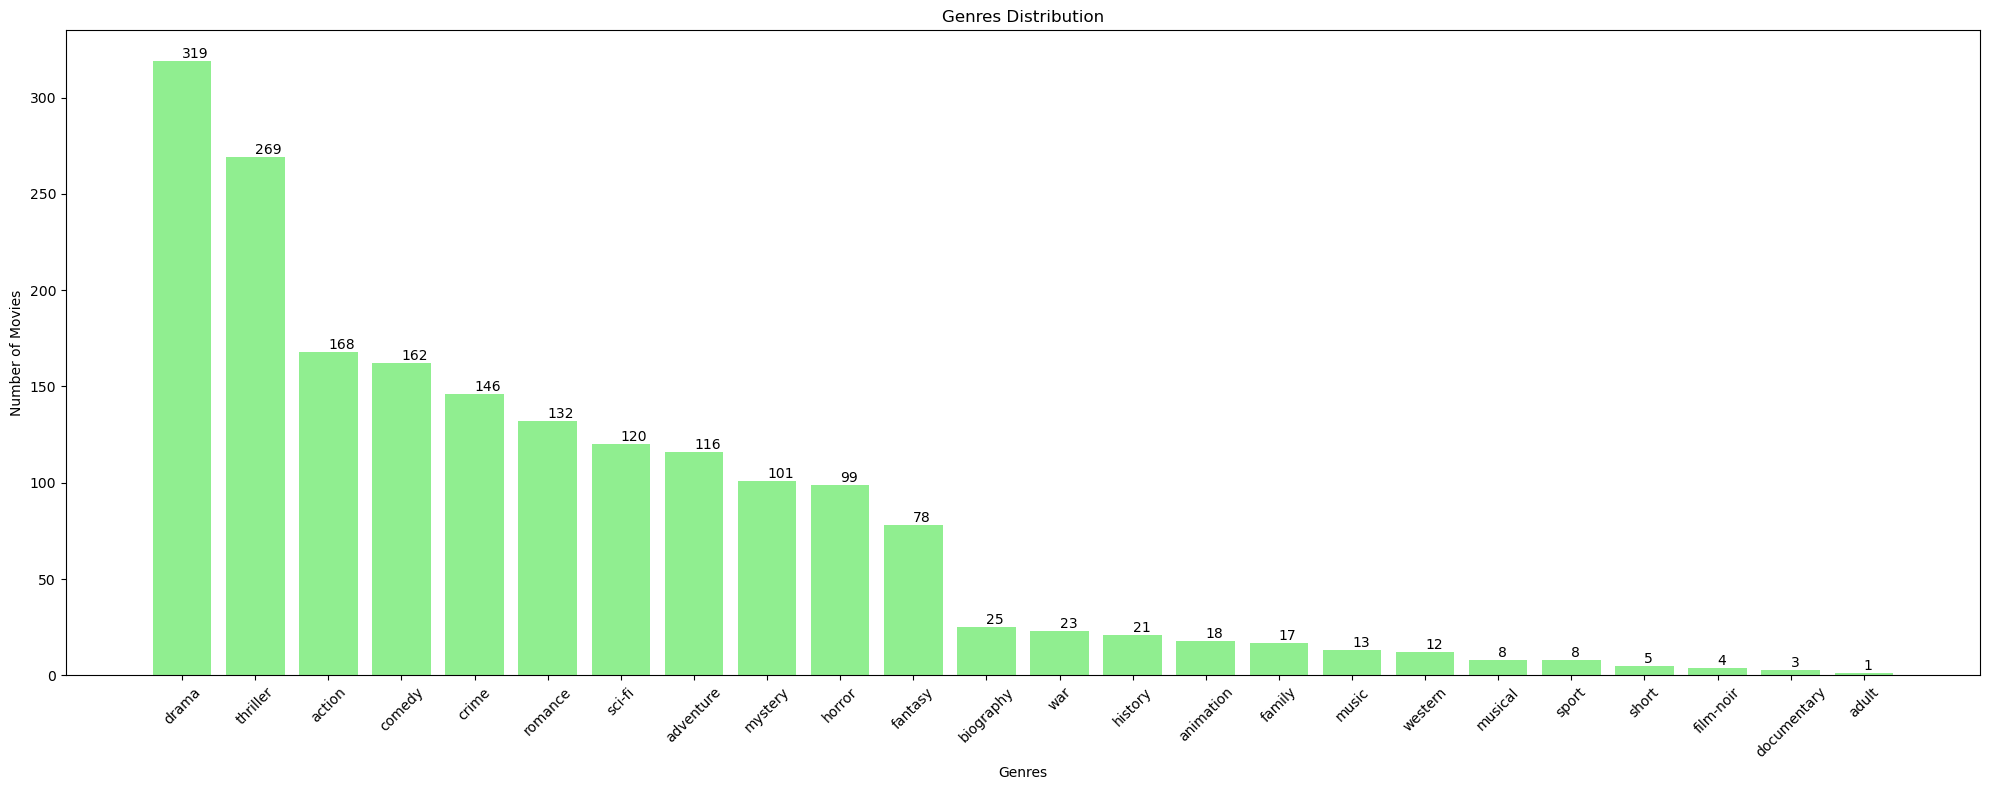

In [23]:
# Count the frequency of each word
word_counts = {}
for word in all_genres:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

# Create a DataFrame from the word counts
df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency
df = df.sort_values(by='Frequency', ascending=False)

# Plotting the data
plt.figure(figsize=(20, 8))
bars = plt.bar(df['Word'], df['Frequency'], color='lightgreen')
plt.bar(df['Word'], df['Frequency'], color='lightgreen')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.title('Genres Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add text labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.tight_layout()
plt.show()

In [24]:
ratings_list = titles['ratingIMDB'].tolist()
print(ratings_list)

[6.9, 6.2, 6.1, 8.4, 6.9, 7.5, 6.3, 5.2, 4.7, 4.9, 6.9, 6.3, 5.8, 7.8, 6.1, 8.5, 8.4, 7.5, 7.4, 5.7, 7.4, 6.0, 7.1, 3.4, 5.9, 6.6, 6.9, 6.3, 8.1, 6.3, 8.1, 6.0, 7.1, 6.4, 8.3, 6.4, 7.8, 7.8, 7.2, 7.6, 8.4, 7.8, 8.8, 7.5, 7.5, 6.8, 7.2, 6.5, 5.3, 6.5, 8.3, 6.3, 8.1, 8.4, 5.9, 8.5, 4.0, 6.4, 5.7, 7.2, 7.6, 6.4, 7.2, 8.0, 5.6, 7.1, 5.6, 4.9, 7.2, 7.5, 6.9, 5.3, 7.7, 6.6, 6.1, 6.9, 8.4, 8.2, 7.7, 7.0, 5.4, 4.5, 5.8, 6.7, 8.1, 6.2, 6.8, 7.0, 7.6, 7.2, 8.1, 7.4, 5.6, 6.3, 8.2, 7.1, 6.4, 6.6, 8.3, 7.5, 6.5, 8.0, 6.4, 8.3, 8.0, 7.6, 7.5, 4.4, 8.3, 7.9, 6.7, 6.8, 5.8, 5.9, 8.6, 4.5, 7.6, 6.2, 6.2, 7.5, 7.3, 5.0, 6.7, 7.6, 7.8, 7.0, 7.7, 6.4, 7.7, 7.7, 7.7, 7.8, 7.7, 5.3, 8.4, 8.2, 5.5, 4.5, 6.7, 8.4, 8.0, 6.8, 6.9, 5.9, 5.5, 5.4, 6.2, 8.2, 7.4, 7.9, 7.1, 8.3, 6.4, 7.8, 6.8, 6.9, 5.9, 6.9, 6.3, 7.2, 6.7, 6.9, 7.5, 7.4, 7.3, 7.1, 8.4, 8.7, 7.9, 5.5, 8.4, 6.9, 4.7, 6.4, 6.9, 7.1, 6.5, 5.4, 7.8, 6.9, 7.0, 8.3, 8.2, 4.2, 6.6, 6.6, 6.6, 6.2, 6.1, 7.4, 8.2, 6.5, 6.5, 7.8, 7.3, 6.3, 7.6, 7.2, 6.4, 6.9,

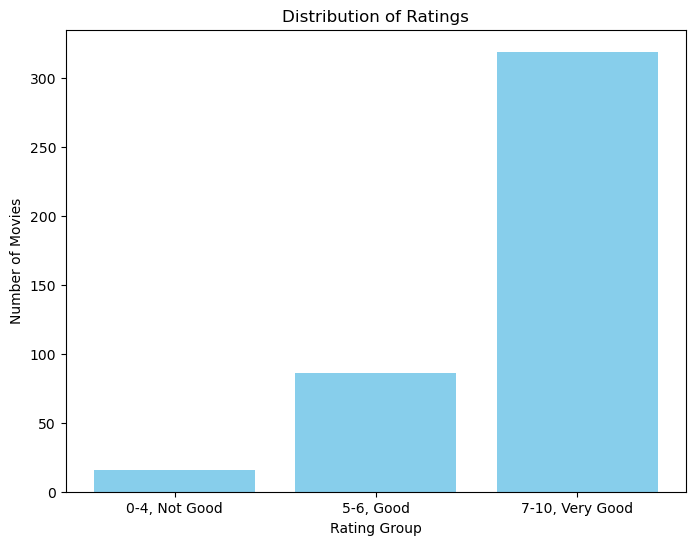

In [25]:
# Categorize ratings into 3 groups (0-4, 5-6, 7-10)
rating_groups = {
    '0-4, Not Good': sum(1 for rating in ratings_list if rating <= 4),
    '5-6, Good': sum(1 for rating in ratings_list if 5 <= rating <= 6),
    '7-10, Very Good': sum(1 for rating in ratings_list if rating >= 7)
}

# Plotting the data
plt.figure(figsize=(8, 6))
plt.bar(rating_groups.keys(), rating_groups.values(), color='skyblue')
plt.xlabel('Rating Group')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings')
plt.show()

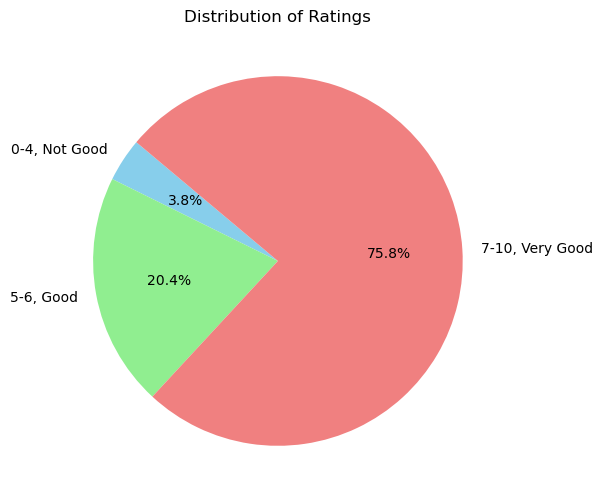

In [26]:
# Plotting the data
plt.figure(figsize=(8, 6))
plt.pie(rating_groups.values(), labels=rating_groups.keys(), autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Distribution of Ratings')
plt.show()

In [27]:
def search_movie_rating(title):
    # Search for the movie by title and get its rating
    movie_rating = titles.loc[titles['title'].str.contains(title, case=False, na=False), 'ratingIMDB']
    
    if not movie_rating.empty:
        return movie_rating.values[0]
    else:
        return "Movie not found or no rating available."

# Example usage:
movie_to_search = input("Enter the title of the movie to search for: ")
rating = search_movie_rating(movie_to_search)
print(f"The rating for '{movie_to_search}' is: {rating}")

Enter the title of the movie to search for: 48.hrs
The rating for '48.hrs' is: 6.9


In [28]:
titles.head()

,title,year,ratingIMDB,votes,genresIMDB
movieID,,,,,
m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


movie to genres 

In [37]:
def find_genres(keyword):
    # Search for the keyword in the movie titles (case insensitive)
    matching_movies = titles[titles['title'].str.contains(keyword, case=False, na=False)]
    
    if not matching_movies.empty:
        # If there's a match, return the movie title and genres as a list of tuples
        x = [(row['title'], row['genresIMDB']) for index, row in matching_movies.iterrows()]
        # Convert list to dictionary
        result_dict = {key: [genre.strip("'") for genre in value.strip("[]").split(", ")] for key, value in x}
        # Convert dictionary to string
        os = f"Movie: {list(result_dict.keys())[0]}\nGenres = {result_dict[list(result_dict.keys())[0]]}"
        return os
    else:
        return "No matching movie found."

movie_name = input("Enter the title of the movie to search genre: ")
genres = find_genres(movie_name)
print(genres)

Enter the title of the movie to search genre: 15 minutes
Movie: 15 minutes
Genres = ["action' 'crime' 'drama' 'thriller"]


In [52]:
Need 

No movies found with the genre: action
